# Jupyter Example 2 for HERMES: PiZero and Dragon2D

In [1]:
from pyhermes import *
from pyhermes.units import TeV, deg, kpc, pc, radian2degree

import astropy.units as u

import numpy as np
import healpy
import matplotlib.pyplot as plt

In [2]:
nside = 512
sun_pos = Vector3QLength(8.0*kpc, 0*pc, 0*pc)
Egamma = 0.1*TeV

In [3]:
dragon2D_proton = Dragon2DCRDensity([Proton])
kamae_crosssection = Kamae06()
neutral_gas = RingModelDensity()

In [4]:
skymap = GammaSkymap(nside=nside, Egamma=Egamma)
mask_edges = [[5*deg, 20*deg], [-5*deg, 60*deg]]
mask = RectangularWindow(*mask_edges)
skymap.setMask(mask)

In [5]:
integrator = PiZeroIntegrator(dragon2D_proton, neutral_gas, kamae_crosssection)
integrator.setupCacheTable(100, 100, 20)
integrator.setSunPosition(sun_pos)
skymap.setIntegrator(integrator)

In [6]:
skymap.compute()

In [7]:
hermes_map = np.array(skymap)

In [8]:
#use_units = skymap.getUnits() # default units for GammaSkymap (GeV^-1 m^-2 s^-1 sr^-1)
use_units = "TeV^-1 cm^-2 s^-1 sr^-1"
skymap_units = u.Quantity(1, use_units)
base_units = skymap_units.unit.si.scale

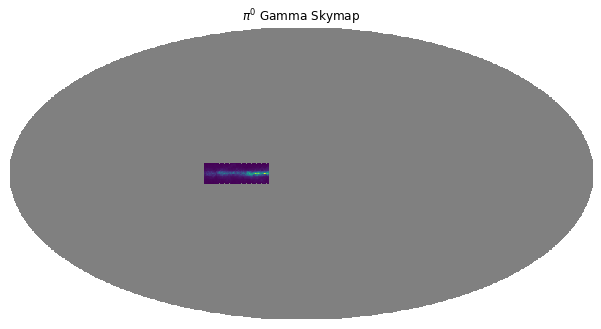

In [9]:
healpy.mollview(hermes_map, cbar=False, title=r"$\pi^0$ Gamma Skymap")

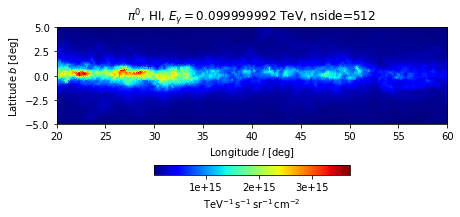

In [10]:
fig = plt.figure(figsize=(7,3))

nside = skymap.getNside()
mask_lon_in_deg = [float(radian2degree(a)) for a in [mask_edges[0][1], mask_edges[1][1]]]
mask_lat_in_deg = [float(radian2degree(a)) for a in [mask_edges[1][0], mask_edges[0][0]]]

projector = healpy.projector.CartesianProj(flipconv="geo")
projector.set_proj_plane_info(xsize=1000, ysize=None,
                              lonra=mask_lon_in_deg,
                              latra=mask_lat_in_deg
                              )
projected_map = projector.projmap(
    hermes_map,
    lambda x, y, z: healpy.pixelfunc.vec2pix(nside, x, y, z, nest=False)  
)
w = ~(np.isnan(projected_map) | np.isinf(projected_map) | healpy.pixelfunc.mask_bad(projected_map, badval=UNSEEN))
projected_map[w] *= base_units
vmin = projected_map[w].min()
vmax = projected_map[w].max()
img = plt.imshow(projected_map, extent=mask_lon_in_deg + mask_lat_in_deg, cmap='jet', interpolation="nearest", origin="lower",
            vmin=vmin, vmax=vmax)

plt.title(r"$\pi^0$, HI, $E_\gamma=${Egamma}, nside={nside}".format(
    nside=nside, Egamma=Egamma.toAstroPy().to("TeV").to_string(format="latex")))
plt.xlabel(r'${\rm Longitude} \; l \; {\rm [deg]}$')
plt.ylabel(r'${\rm Latitude} \; b \; {\rm [deg]}$')

cb = fig.colorbar(img, orientation='horizontal', shrink=.5, pad=0.25, format='%.0e')
cb.ax.xaxis.set_label_text(skymap_units.unit.to_string(format='latex_inline'))
cb.solids.set_edgecolor("face")